In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
#import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [120]:
# Parametreler ayarlanıyor
data_dir = "/content/drive/My Drive/Piton_Uygulamalarim/raylar"
batch_size = 32
img_height = 540
img_width = 120

In [121]:
# Eğitim Verisi Ayarlanıyor
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1810 files belonging to 2 classes.
Using 1448 files for training.


In [122]:
# Doğrulama Verisi Ayarlanıyor
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1810 files belonging to 2 classes.
Using 362 files for validation.


In [123]:
# Sınıf İsimleri Sorgulanıyor
class_names = train_ds.class_names
print(class_names)

['Kirik', 'Saglam']


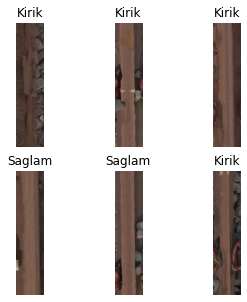

In [124]:
# Eğitim verilerinden 6 tanesini görüntüle
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [125]:
# Verileri Standartlaştırma [0, 1] aralığı
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print("Resim 1'deki en küçük piksel değeri:", np.min(first_image), "en büyük piksel değeri:", np.max(first_image))

Resim 1'deki en küçük piksel değeri: 0.003921569 en büyük piksel değeri: 0.6862745


In [126]:
# Veri örneklerini büyütme
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [127]:
# Modeli Oluşturalım
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.15), # Bırakma
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [128]:
# Modeli Derleyelim
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [129]:
# Model Özet Bilgileri
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 540, 120, 3)       0         
                                                                 
 rescaling_17 (Rescaling)    (None, 540, 120, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 538, 118, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 269, 59, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 267, 57, 32)       4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 133, 28, 32)      0         
 g2D)                                                

In [130]:
# Modelin Eğitilmesi
epochs=9
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/9
46/46 [==============================] - 113s 2s/step - loss: 0.7077 - accuracy: 0.5028 - val_loss: 0.6914 - val_accuracy: 0.6740
Epoch 2/9
46/46 [==============================] - 111s 2s/step - loss: 0.6932 - accuracy: 0.5262 - val_loss: 0.6908 - val_accuracy: 0.6989
Epoch 3/9
46/46 [==============================] - 110s 2s/step - loss: 0.6885 - accuracy: 0.5566 - val_loss: 0.6723 - val_accuracy: 0.6492
Epoch 4/9
46/46 [==============================] - 109s 2s/step - loss: 0.6701 - accuracy: 0.5994 - val_loss: 0.6278 - val_accuracy: 0.7099
Epoch 5/9
46/46 [==============================] - 109s 2s/step - loss: 0.6311 - accuracy: 0.6554 - val_loss: 0.5856 - val_accuracy: 0.6934
Epoch 6/9
46/46 [==============================] - 110s 2s/step - loss: 0.5872 - accuracy: 0.6844 - val_loss: 0.5274 - val_accuracy: 0.7320
Epoch 7/9
46/46 [==============================] - 111s 2s/step - loss: 0.5839 - accuracy: 0.6837 - val_loss: 0.5251 - val_accuracy: 0.7735
Epoch 8/9
46/46 [===

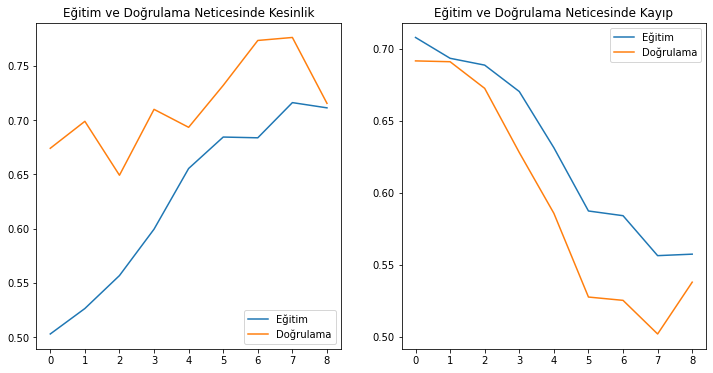

In [131]:
# Eğitim Sonuçlarının Görselleştirilmesi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim')
plt.plot(epochs_range, val_acc, label='Doğrulama')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Neticesinde Kesinlik')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim')
plt.plot(epochs_range, val_loss, label='Doğrulama')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Neticesinde Kayıp')
plt.show()

In [132]:
# Yeni ray verilerini tahmin için gerekli fonksiyon hazırlanıyor
def tahmin(resim, gercek):
  konum = "/content/drive/My Drive/Piton_Uygulamalarim/test/"
  konum = konum + resim

  img = tf.keras.utils.load_img(
      konum, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "GERÇEK SINIF: {} | TAHMİN EDİLEN: {} . Doğruluk Oranı: %{:.2f}"
      .format(gercek, class_names[np.argmax(score)], 100 * np.max(score))
  )

In [133]:
# Test klasöründeki tüm dosyaları okuyup tahmin edelim...
saglam_test_imgeleri = listdir("/content/drive/My Drive/Piton_Uygulamalarim/test/t_saglam/")
kirik_test_imgeleri = listdir("/content/drive/My Drive/Piton_Uygulamalarim/test/t_kirik/")

sSay = kSay = 1

for s_img in saglam_test_imgeleri:
  print(sSay, " ", end="")
  tahmin("t_saglam/" + s_img, "Saglam")
  sSay += 1

print(90 * "-")

for k_img in kirik_test_imgeleri:
  print(kSay, " ", end="")
  tahmin("t_kirik/" + k_img, "Kirik")
  kSay += 1



1  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %75.65
2  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %80.22
3  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %74.72
4  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %74.66
5  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %52.58
6  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %82.64
7  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %51.35
8  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %85.89
9  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %81.04
10  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %50.26
11  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğruluk Oranı: %65.91
12  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %71.57
13  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Kirik . Doğruluk Oranı: %54.95
14  GERÇEK SINIF: Saglam | TAHMİN EDİLEN: Saglam . Doğr